In [1]:
cd ..

/home/hantoine/Documents/Cours/Concordia/2019-Winter/SOEN_691_Big_Data_Analytics/project/accident-prediction-montreal


In [2]:
from imblearn.datasets import fetch_datasets
from sklearn.model_selection import train_test_split

satimage = fetch_datasets()['mammography']
X, y = satimage.data, satimage.target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    random_state=0)

In [4]:
sum = __builtin__.sum
imbalance_ratio = sum(y == -1) / sum(y == 1)
print((sum(y == -1), sum(y == 1)))
print(imbalance_ratio)
print(f'{100/imbalance_ratio}%')

(10923, 260)
42.011538461538464
2.3802984528060054%


In [5]:
%matplotlib inline
import sys
sys.path.insert(0, '/home/hantoine/concordia/bigdata/project/spark/python')
from utils import init_spark
spark = init_spark()

spark.version

Spark Session created
Parameters:
	spark.driver.extraClassPath: ./data/xgboost4j-spark-0.72.jar:./data/xgboost4j-0.72.jar
	spark.app.id: local-1556915919520
	spark.network.timeout: 300s
	spark.master: local[10]
	spark.executor.id: driver
	spark.driver.host: laptop-hantoine.wireless.concordia.ca
	spark.driver.port: 33121
	spark.app.name: Accident prediction
	spark.cleaner.periodicGC.interval: 5min
	spark.serializer: org.apache.spark.serializer.KryoSerializer
	spark.driver.memory: 6g
	spark.rdd.compress: True
	spark.serializer.objectStreamReset: 100
	spark.submit.pyFiles: 
	spark.submit.deployMode: client
	spark.ui.showConsoleProgress: true


'3.0.0-SNAPSHOT'

In [6]:
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import lit, monotonically_increasing_id

train_examples = map(lambda r: (Vectors.dense(r[0]), 0 if int(r[1]) == -1 else 1), zip(X_train, y_train))
train_set = spark.createDataFrame(train_examples, schema=["features", "label"])
test_examples = map(lambda r: (Vectors.dense(r[0]), 0 if int(r[1]) == -1 else 1), zip(X_test, y_test))
test_set = spark.createDataFrame(test_examples, schema=["features", "label"])
train_set = train_set.withColumn('id', monotonically_increasing_id())
test_set = test_set.withColumn('id', -1 * monotonically_increasing_id() - 1)

In [7]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator
from pyspark.ml import Pipeline
from random_undersampler import RandomUnderSampler
from class_weighter import ClassWeighter
from pyspark.sql.functions import col

imbalance_ratio = (train_set.filter(col('label') == 0).count()
                    / train_set.filter(col('label') == 1).count())

rf = RandomForestClassifier(labelCol="label",
                            featuresCol="features",
                            cacheNodeIds=True,
                            maxDepth=30,
                            impurity='gini',
                            featureSubsetStrategy='sqrt',
                            minInstancesPerNode=2,
                            numTrees=50,
                            subsamplingRate=1.0,
                            maxMemoryInMB=768
                           )
brf = RandomForestClassifier(labelCol="label",
                            featuresCol="features",
                            cacheNodeIds=True,
                            maxDepth=30,
                            impurity='gini',
                            featureSubsetStrategy='sqrt',
                            weightCol='weight',
                            minInstancesPerNode=2,
                            numTrees=50,
                            subsamplingRate=1.0,
                            maxMemoryInMB=768
                           )
cw = ClassWeighter().setClassWeight([1/imbalance_ratio, 1.0])
ru = (RandomUnderSampler()
      .setIndexCol('id')
      .setTargetImbalanceRatio(1.0))

pipeline_urf = Pipeline().setStages([ru, rf])
pipeline_rf = Pipeline().setStages([rf])
pipeline_brf = Pipeline().setStages([cw, brf])

model_rf = pipeline_rf.fit(train_set)
model_urf = pipeline_urf.fit(train_set)
model_brf = pipeline_brf.fit(train_set)
pred_rf = model_rf.transform(test_set)
pred_urf = model_urf.transform(test_set)
pred_brf = model_brf.transform(test_set)

In [8]:
from pyspark.sql.functions import when
y_pred_rf_sp = pred_rf.select(when(col('prediction') == 0, -1).otherwise(1)).toPandas().values
y_pred_brf_sp = pred_brf.select(when(col('prediction') == 0, -1).otherwise(1)).toPandas().values
y_pred_urf_sp = pred_urf.select(when(col('prediction') == 0, -1).otherwise(1)).toPandas().values

In [13]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
rf = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=-1, max_depth=30)
brf = BalancedRandomForestClassifier(n_estimators=50, random_state=0, n_jobs=-1, max_depth=30)
rf.fit(X_train, y_train)
brf.fit(X_train, y_train)

y_pred_proba_rf = rf.predict_proba(X_test)
y_pred_proba_brf = brf.predict_proba(X_test)
y_pred_rf = rf.predict(X_test)
y_pred_brf = brf.predict(X_test)

In [14]:
pred_rf_il = map(lambda r: (Vectors.dense(r[0]), 0 if int(r[1]) == -1 else 1), zip(y_pred_proba_rf, y_test))
pred_rf_il = spark.createDataFrame(pred_rf_il, schema=["probability", "label"])
pred_rf_il = pred_rf_il.withColumn('rawPrediction', col('probability'))
pred_brf_il = map(lambda r: (Vectors.dense(r[0]), 0 if int(r[1]) == -1 else 1), zip(y_pred_proba_brf, y_test))
pred_brf_il = spark.createDataFrame(pred_brf_il, schema=["probability", "label"])
pred_brf_il = pred_brf_il.withColumn('rawPrediction', col('probability'))

In [161]:
from random_forest import compute_threshold_dependent_metrics
from evaluate import evaluate_binary_classifier
from sklearn.metrics import balanced_accuracy_score

results = {
    'algo': ['imbalanced-learn rf', 'imbalanced-learn brf', 'spark brf', 'spark rf', 'spark urf'],
    'y_preds': [y_pred_rf, y_pred_brf, y_pred_brf_sp, y_pred_rf_sp, y_pred_urf_sp],
    'preds': [pred_rf_il, pred_brf_il, pred_brf, pred_rf, pred_urf]
}
results['balanced_accuracy'] = [balanced_accuracy_score(y_test, y_pred) for y_pred in results['y_preds']]
results['AUCs'] = [evaluate_binary_classifier(pred) for pred in results['preds']]
results['Area under PR'] = [AUCs[0] for AUCs in results['AUCs']]
results['Area under ROC'] = [AUCs[1] for AUCs in results['AUCs']]
metrics = [compute_threshold_dependent_metrics(spark, pred, 10) for pred in results['preds']]
del results['AUCs']
del results['y_preds']
del results['preds']
import pandas as pd
results = pd.DataFrame(results).set_index('algo')

In [1]:
print(results.drop(columns=['balanced_accuracy']).round(3).to_latex())

NameError: name 'results' is not defined

In [163]:
results.drop(columns=['balanced_accuracy']).round(3)

,Area under PR,Area under ROC
algo,,
imbalanced-learn rf,0.759,0.932
imbalanced-learn brf,0.678,0.956
spark brf,0.684,0.960
spark rf,0.726,0.951
spark urf,0.607,0.952


Text(0, 0.5, 'Precision')

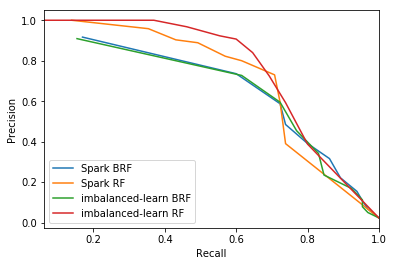

In [164]:
ax = None
ax = (metrics[2][['Recall', 'Precision']]
      .append(pd.DataFrame({'Precision': [0.916667], 'Recall': [0.169231]}), sort=True) # with threshold at 0.9975
      .dropna()
      .rename(columns={'Precision': 'Spark BRF'})
      .plot(x='Recall', y='Spark BRF'))
ax = (metrics[3][['Recall', 'Precision']]
      .dropna()
      .rename(columns={'Precision': 'Spark RF'})
      .plot(x='Recall', y='Spark RF', ax=ax))
# ax = (metrics[4][['Recall', 'Precision']]
#       .dropna()
#       .rename(columns={'Precision': 'URF'})
#       .plot(x='Recall', y='URF', ax=ax))
ax = (metrics[1][['Recall', 'Precision']]
      .append(pd.DataFrame({'Precision': [0.909091], 'Recall': [0.153846]})) # with threshold at 0.9975
      .dropna()
      .rename(columns={'Precision': 'imbalanced-learn BRF'})
      .plot(x='Recall', y='imbalanced-learn BRF', ax=ax))
ax = (metrics[0][['Recall', 'Precision']]
      .dropna()
      .rename(columns={'Precision': 'imbalanced-learn RF'})
      .plot(x='Recall', y='imbalanced-learn RF', ax=ax))
ax = ax.set_ylabel('Precision')
ax

Text(0, 0.5, 'Recall')

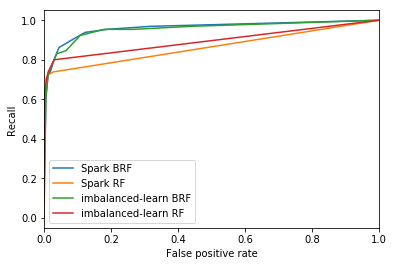

In [132]:
ax = (metrics[2][['Recall', 'False positive rate']]
      .dropna()
      .rename(columns={'Recall': 'Spark BRF'})
      .plot(x='False positive rate', y='Spark BRF'))
ax = (metrics[3][['Recall', 'False positive rate']]
      .dropna()
      .rename(columns={'Recall': 'Spark RF'})
      .plot(x='False positive rate', y='Spark RF', ax=ax))
# ax = (metrics[4][['Recall', 'False positive rate']]
#       .dropna()
#       .rename(columns={'Recall': 'URF'})
#       .plot(x='False positive rate', y='URF', ax=ax))
ax = (metrics[1][['Recall', 'False positive rate']]
      .dropna()
      .rename(columns={'Recall': 'imbalanced-learn BRF'})
      .plot(x='False positive rate', y='imbalanced-learn BRF', ax=ax))
ax = (metrics[0][['Recall', 'False positive rate']]
      .dropna()
      .rename(columns={'Recall': 'imbalanced-learn RF'})
      .plot(x='False positive rate', y='imbalanced-learn RF', ax=ax))
ax = ax.set_ylabel('Recall')
ax